In [1]:
# Run this cell to test if the LinearChain object is gonna give us a headache.
using IonSim

@time chain = LinearChain(
        ions=[Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")]), Ca40([("S1/2", -1/2, "S"), ("D5/2", -1/2, "D")])], 
        comfrequencies=(x=3e6,y=3e6,z=2.5e5), selectedmodes=(;z=[1],)
    )
chain = Nothing;


0
1
2
3
4
5
6
7
8
9  7.637676 seconds (14.90 M allocations: 958.786 MiB, 9.49% gc time, 99.58% compilation time: <1% of which was recompilation)


In [2]:
using QuantumOptics
using IonSim
import PyPlot
using Random, Distributions
Random.seed!(0)

include("./single_qubit_chamber.jl")
using .SingleQubitChamber: construct_single_qubit_chamber, RX, RY, RZ
const plt = PyPlot;

Globals

In [3]:
N_SAMPLES = Int(1e4)

using .SingleQubitChamber: CALCIUM40 
TIMESCALE = 1e-6 
TRAP_FREQUENCY = 1e6
B_STRENGTH = 4e-4
PI_TIME = 2e-6;

More globals

In [4]:
chamber = construct_single_qubit_chamber(TRAP_FREQUENCY, PI_TIME)

WAVELENGTH = transitionwavelength(CALCIUM40, ("S", "D"), chamber)
wavelength!(chamber.lasers[1], WAVELENGTH)

INTENSITY = intensity_from_pitime(chamber.lasers[1], PI_TIME, CALCIUM40, ("S", "D"), chamber);

Z_PLUS = CALCIUM40["S"]
VIB_MODE =  IonSim.modes(chamber)[1]
ψ0_MOTIONAL = VIB_MODE[0] # GLOBAL: ground state of the first vibrational mode

chain = Nothing
laser = Nothing
chamber = Nothing;


0
1
2
3
4
5
6
7
8
9

Helper function for plotting

In [5]:
function plot_populations(chamber, tout, sol)
    vibrational_mode = IonSim.modes(chamber)[1]

    Z_plus = CALCIUM40["S"]
    Z_minus = CALCIUM40["D"]

    X_plus = (Z_plus + Z_minus)/√2
    X_minus = (Z_plus - Z_minus)/√2

    Y_plus = (Z_plus + im*Z_minus)/√2
    Y_minus = (Z_plus - im*Z_minus)/√2

    prob_X_plus = expect(dm(X_plus) ⊗ one(vibrational_mode), sol)
    prob_X_minus = expect(dm(X_minus) ⊗ one(vibrational_mode), sol)
    prob_Y_plus = expect(dm(Y_plus) ⊗ one(vibrational_mode), sol)
    prob_Y_minus = expect(dm(Y_minus) ⊗ one(vibrational_mode), sol)
    prob_Z_plus = expect(dm(Z_plus) ⊗ one(vibrational_mode), sol)
    prob_Z_minus = expect(dm(Z_minus) ⊗ one(vibrational_mode), sol)

    fig, (x_ax, y_ax, z_ax) = plt.subplots(1, 3, figsize=(15, 5))
    x_ax.plot(tout, prob_X_plus, label="|X+⟩", linewidth=4)
    x_ax.plot(tout, prob_X_minus, "--", label="|X-⟩", linewidth=4)
    x_ax.set_xlim(tout[1], tout[end])
    x_ax.set_ylim(0, 1)
    x_ax.legend(loc=1)
    x_ax.set_xlabel("Time (μs)")

    y_ax.plot(tout, prob_Y_plus, label="|Y+⟩", linewidth=4)
    y_ax.plot(tout, prob_Y_minus, "--", label="|Y-⟩", linewidth=4)
    y_ax.set_xlim(tout[1], tout[end])
    y_ax.set_ylim(0, 1)
    y_ax.legend(loc=1)
    y_ax.set_xlabel("Time (μs)")

    z_ax.plot(tout, prob_Z_plus, label="|Z+⟩", linewidth=4)
    z_ax.plot(tout, prob_Z_minus, "--", label="|Z-⟩", linewidth=4)
    z_ax.set_xlim(tout[1], tout[end])
    z_ax.set_ylim(0, 1)
    z_ax.legend(loc=1)
    z_ax.set_xlabel("Time (μs)")

    return fig
end

plot_populations (generic function with 1 method)

Per "Experimental Bayesian Calibration..." (https://journals.aps.org/prxquantum/abstract/10.1103/PRXQuantum.3.020350), we have the following experimental parameter uncertainties:

Rabi frequency: $\sigma_\Omega = 0.2 \Omega_{\text{opt}}$ 

Center-line frequency: $\sigma_{\omega_{cl}} = 2 \times 2\pi \text{kHz} \Longrightarrow \sigma_{f_{cl}} = 2 kHz$

Sideband detuning: $\sigma_\delta = 2 \times 2\pi \text{kHz} $

Phase: $\sigma_{\Delta \phi} = 0.16\pi$

## 1. Compute uncertainty in intensity

We use a semi-analytical approach to estimate the uncertainty in intensity, $\sigma_I$:

We know $I \propto \Omega^2 \Longrightarrow I = \kappa \Omega^2$. This gives the result: $\sigma_I^2 = \kappa^2 \bigg( 2\sigma_{\Omega}^4 + 4\bar{\Omega}^2 \sigma_{\Omega}^2 \bigg)$. (See $\texttt{Intensity Uncertainty.pdf}$ for the derivation.) The exact value of $\kappa$ is the object of future work, but what we can do here is just estimate $\kappa$ through the following: $\kappa \approx I_{\text{opt}}/\Omega_{\text{opt}}^2$. 



In [6]:
function find_rabi_freq(tout, sol, timescale)
    prob_Z_plus = expect(dm(Z_PLUS) ⊗ one(VIB_MODE), sol);
    prob_Z_plus_1up = broadcast(abs, prob_Z_plus[2:end]);
    max_prob_idx = findall(broadcast(abs, prob_Z_plus_1up.-maximum(prob_Z_plus_1up)) .< 1e-8)[1];
    period = tout[max_prob_idx+1]-tout[1];
    period *= timescale
    freq = 1/period
    return freq
end

find_rabi_freq (generic function with 1 method)

(See $\texttt{rabi\_freq\_func\_test.ipynb}$ for a test of the $\texttt{find\_rabi\_freq}$ function.)


0
1
2
3
4
5
6
7
8
9

/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/aelabd/.julia/conda/3/x86_64/lib/python3.10/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


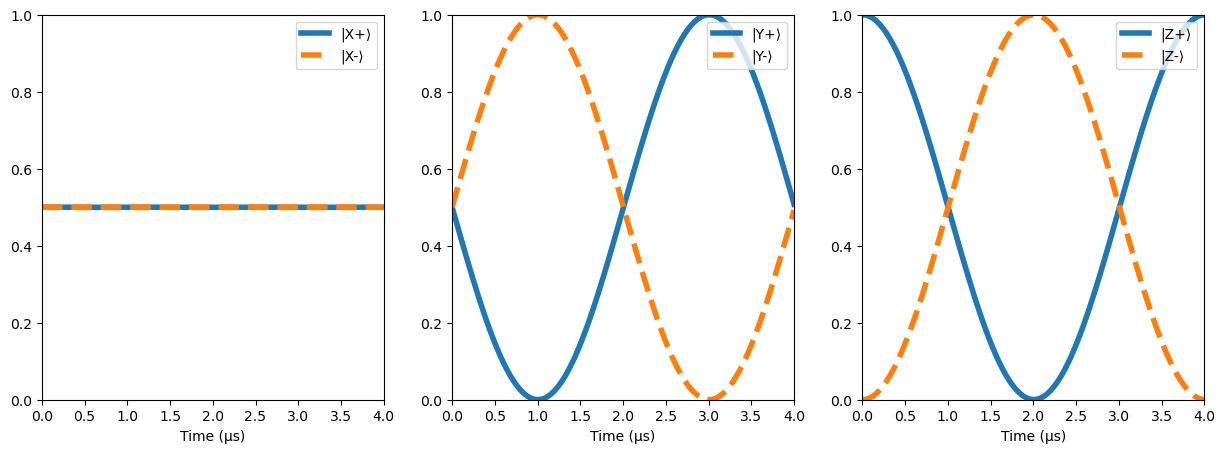

In [7]:
chamber = construct_single_qubit_chamber(
    TRAP_FREQUENCY,
    PI_TIME,
    intensity = INTENSITY,
    wavelength = WAVELENGTH
)
# construct_single_qubit_chamber() automatically sets λ=transition-wavelength and I=pitime-intensity

# Initial state
ψ0_electronic = CALCIUM40["S"]
ψ0 = Z_PLUS ⊗ ψ0_MOTIONAL# GLOBAL: initial state for all the simulations

# RX(2π)
tout, ψt = RX(2π, chamber, ψ0, PI_TIME, TIMESCALE);
plot_populations(chamber, tout, ψt)

$\sigma_I^2 = \kappa^2 \bigg( 2\sigma_{\Omega}^4 + 4\bar{\Omega}^2 \sigma_{\Omega}^2 \bigg)$.

In [8]:
Ω_opt = find_rabi_freq(tout, ψt, TIMESCALE)
κ = INTENSITY/(Ω_opt^2)

σΩ = 0.2Ω_opt
σI = κ*sqrt(2*(σΩ^4) + 4*(σΩ^2)*Ω_opt^2 )
σI/INTENSITY

0.4039801975344831

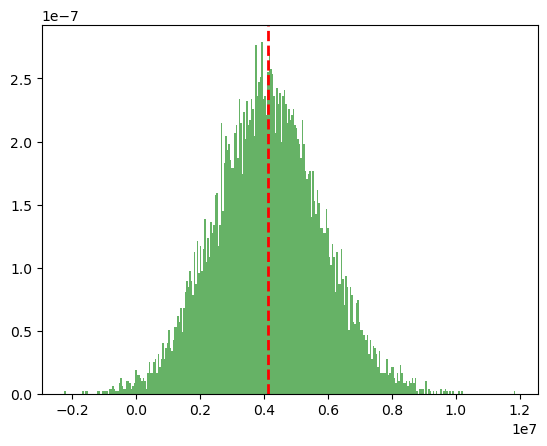

In [9]:
N_I = Normal(INTENSITY, σI)
I_dist = rand(N_I, N_SAMPLES)

fig = plt.figure()
plt.hist(I_dist, bins=300, density=true, alpha=0.6, color="g")
plt.axvline(x=INTENSITY, color="r", linestyle="--", linewidth=2)
plt.display(fig)

# 2. Vary intensity

In [10]:
# Initial state
ψ0_electronic = CALCIUM40["S"]
ψ0 = Z_PLUS ⊗ ψ0_MOTIONAL; # GLOBAL: initial state for all the simulations

In [12]:
chamber = construct_single_qubit_chamber(
    TRAP_FREQUENCY,
    PI_TIME,
    intensity = INTENSITY,
    wavelength = WAVELENGTH
)
fidelities_intensity = zeros(length(I_dist))

for i in 1:N_SAMPLES
    if i%Int(1e3)==0
        print("\n", i)
        flush(stdout)
    end

    I = I_dist[i]
    if I < 0
        fidelities_intensity[i] = NaN
    else
        intensity!(chamber.lasers[1], I)
        tout, ψt = RX(2π, chamber, ψ0, PI_TIME, TIMESCALE)
        fidelities_intensity[i] = real(fidelity(dm(ψt[end]), dm(ψ0)))
    end
end


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000

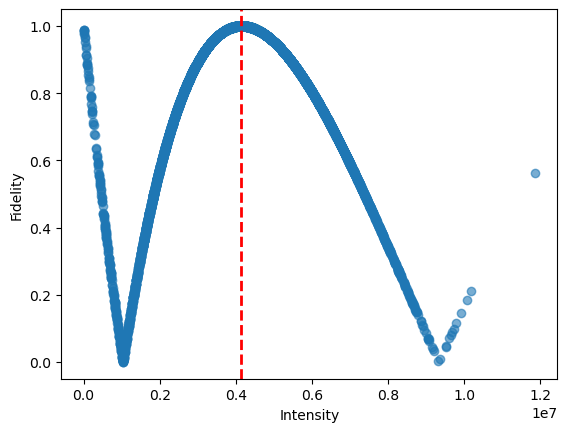

In [13]:
fig = plt.figure()
plt.plot(I_dist, fidelities_intensity, "o", alpha=0.6)
plt.axvline(x=INTENSITY, color="r", linestyle="--", linewidth=2)
plt.xlabel("Intensity")
plt.ylabel("Fidelity")
plt.display(fig)

In [14]:
fidelities_intensity = fidelities_intensity[.~isnan.(fidelities_intensity)]
print("\nlength(fidelities_intensity) = ", length(fidelities_intensity))


length(fidelities_intensity) = 9935

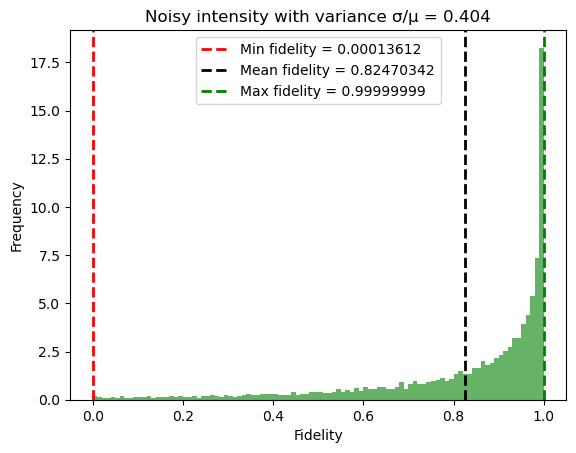

In [15]:
fig = plt.figure()
plt.hist(fidelities_intensity, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_intensity), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_intensity); digits=8))")
plt.axvline(mean(fidelities_intensity), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_intensity); digits=8))")
plt.axvline(maximum(fidelities_intensity), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_intensity); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.title("Noisy intensity with variance σ/μ = $(round(σI/INTENSITY; digits=3))")
plt.legend()
plt.display(fig)

# 3. Vary center-line frequency

See **molmer_sorensen\molmer_sorensen_scans.ipynb** to see how we computed $\delta\lambda\_\texttt{MAX}$.

In [11]:
δλ_MAX = 1e-15
C0 = 2.99792458e8
FREQUENCY = C0/WAVELENGTH
σf = 2e3

2000.0

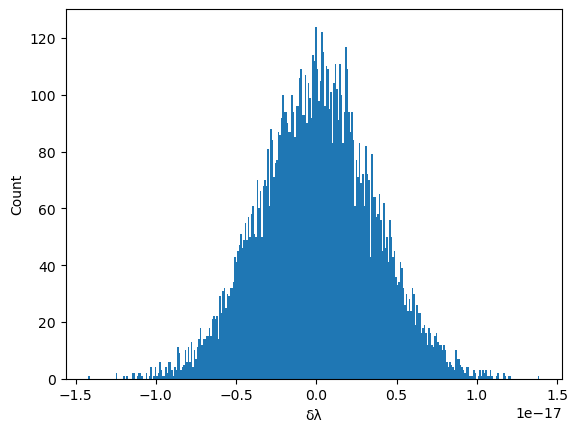

In [12]:
N_f = Normal(FREQUENCY, σf)
f_dist = rand(N_f, N_SAMPLES)

λ_dist = C0./f_dist
δλ_dist = WAVELENGTH .- λ_dist;
fig = plt.figure()
plt.hist(δλ_dist, bins=300)
plt.xlabel("δλ")
plt.ylabel("Count")
plt.display(fig)

In [13]:
sum(broadcast(abs, δλ_dist) .> δλ_MAX)

0

Perfect

In [19]:
chamber = construct_single_qubit_chamber(
    TRAP_FREQUENCY,
    PI_TIME,
    intensity = INTENSITY,
    wavelength = WAVELENGTH
)
fidelities_frequency = zeros(length(f_dist))

for i in 1:N_SAMPLES
    if i%Int(1e3)==0
        print("\n", i)
        flush(stdout)
    end

    f = f_dist[i]
    λ = λ_dist[i]

    wavelength!(chamber.lasers[1], λ)
    tout, ψt = RX(2π, chamber, ψ0, PI_TIME, TIMESCALE)
    fidelities_frequency[i] = real(fidelity(dm(ψt[end]), dm(ψ0)))
end


1000
2000
3000
4000
5000
6000
7000
8000
9000
10000

Didn't need to use a finite RWA-cutoff. Nice.

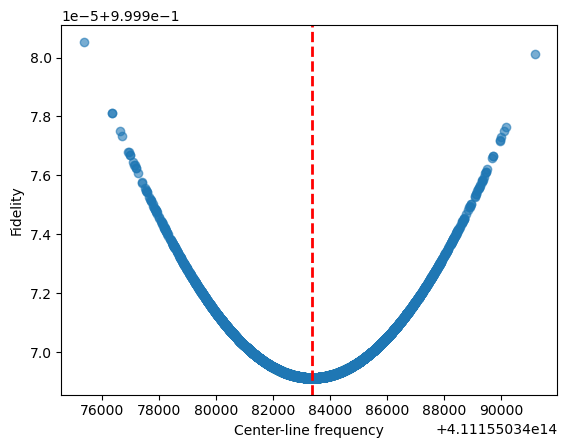

In [20]:
fig = plt.figure()
plt.plot(f_dist, fidelities_frequency, "o", alpha=0.6)
plt.axvline(x=FREQUENCY, color="r", linestyle="--", linewidth=2)
plt.xlabel("Center-line frequency")
plt.ylabel("Fidelity")
plt.display(fig)

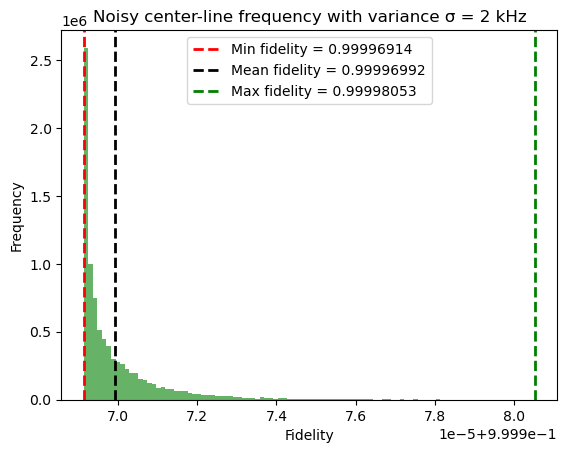

In [21]:
fig = plt.figure()
plt.hist(fidelities_frequency, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_frequency), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_frequency); digits=8))")
plt.axvline(mean(fidelities_frequency), color="k", linestyle="--", linewidth=2, label="Mean fidelity = $(round(mean(fidelities_frequency); digits=8))")
plt.axvline(maximum(fidelities_frequency), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_frequency); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Frequency")
plt.title("Noisy center-line frequency with variance σ = 2 kHz")
plt.legend()
plt.display(fig)

# 4. Vary trap-frequency

Uncertainty in trap-frequency is uncertainty in detuning. So we can just use the same exact value here. 

In [14]:
σΔ = 2e3
σν = σΔ

2000.0

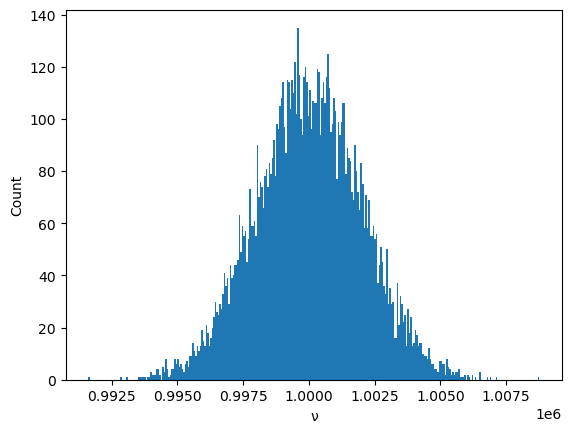

In [15]:
N_ν  = Normal(TRAP_FREQUENCY, σν)
ν_dist = rand(N_ν, N_SAMPLES)

fig = plt.figure()
plt.hist(ν_dist, bins=300)
plt.xlabel("ν")
plt.ylabel("Count")
plt.display(fig)

In [16]:
fidelities_trap_frequency = zeros(length(ν_dist))

for i in 1:N_SAMPLES
    if i%Int(1e3)==0
        print("\n", i)
        flush(stdout)
    end

    ν = ν_dist[i]
    chamber = construct_single_qubit_chamber(
        ν,
        PI_TIME,
        intensity = INTENSITY,
        wavelength = WAVELENGTH
    )

    tout, ψt = RX(2π, chamber, ψ0, PI_TIME, TIMESCALE)
    fidelities_trap_frequency[i] = real(fidelity(dm(ψt[end]), dm(ψ0)))
end


0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9

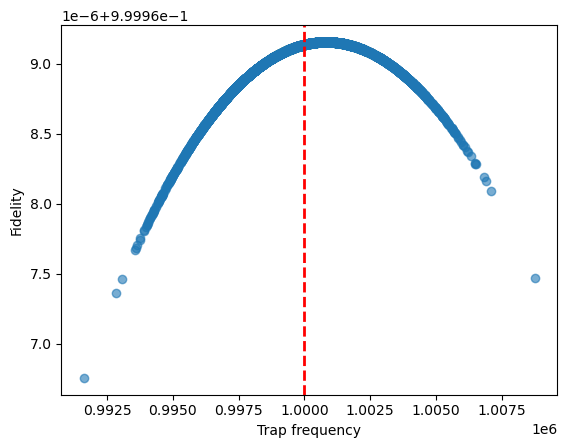

In [17]:
fig = plt.figure()
plt.plot(ν_dist, fidelities_trap_frequency, "o", alpha=0.6)
plt.axvline(x=TRAP_FREQUENCY, color="r", linestyle="--", linewidth=2)
plt.xlabel("Trap frequency")
plt.ylabel("Fidelity")
plt.display(fig)

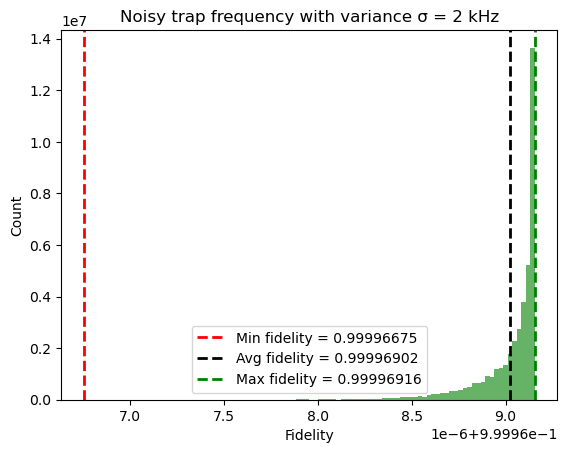

In [18]:
fig = plt.figure()
plt.hist(fidelities_trap_frequency, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities_trap_frequency), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities_trap_frequency); digits=8))")
plt.axvline(mean(fidelities_trap_frequency), color="k", linestyle="--", linewidth=2, label="Avg fidelity = $(round(mean(fidelities_trap_frequency); digits=8))")
plt.axvline(maximum(fidelities_trap_frequency), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities_trap_frequency); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("Noisy trap frequency with variance σ = 2 kHz")
plt.legend()
plt.display(fig)

# 5. Simulation with all 3 noisy parameters

In [19]:
fidelities = zeros(N_SAMPLES)

for i in 1:N_SAMPLES
    if i%Int(1e3)==0
        print("\n", i)
        flush(stdout)
    end

    I = rand(N_I, 1)[1]
    f = rand(N_f, 1)[1]
    λ = C0/f
    ν = rand(N_ν,1)[1]

    if I<0
        fidelities[i] = NaN
    else
        try
            chamber = construct_single_qubit_chamber(
                ν,
                PI_TIME,
                intensity = I,
                wavelength = λ,
            )
            tout, ψt = RX(2π, chamber, ψ0, PI_TIME, TIMESCALE)
            fidelities[i] = abs(fidelity(dm(ψt[end]), dm(ψ0)))
        catch
            fidelities[i] = NaN
        end
    end

end



0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9
0
1
2
3
4
5
6
7
8
9

In [20]:
fidelities = fidelities[.~isnan.(fidelities)]
length(fidelities)

9929

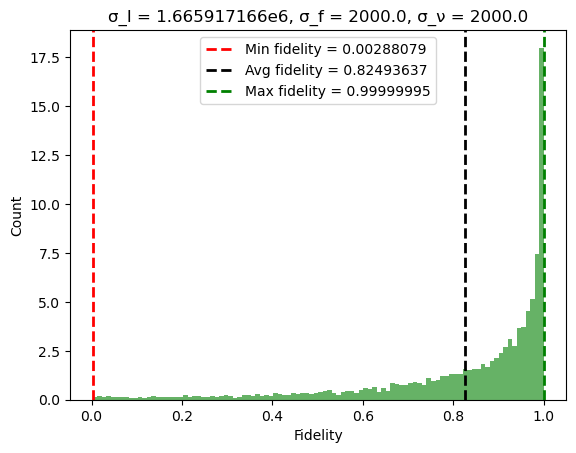

In [21]:
fig = plt.figure()
plt.hist(fidelities, bins=100, density=true, alpha=0.6, color="g")
plt.axvline(minimum(fidelities), color="r", linestyle="--", linewidth=2, label="Min fidelity = $(round(minimum(fidelities); digits=8))")
plt.axvline(mean(fidelities), color="k", linestyle="--", linewidth=2, label="Avg fidelity = $(round(mean(fidelities); digits=8))")
plt.axvline(maximum(fidelities), color="g", linestyle="--", linewidth=2, label="Max fidelity = $(round(maximum(fidelities); digits=8))")
plt.xlabel("Fidelity")
plt.ylabel("Count")
plt.title("σ_I = $(round(σI; digits=3)), σ_f = $(round(σΔ; digits=3)), σ_ν = $(round(σν; digits=3))")
plt.legend()
plt.display(fig)